2025-04-24 20:25:08.514010: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-24 20:25:08.561180: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-24 20:25:12.574216: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


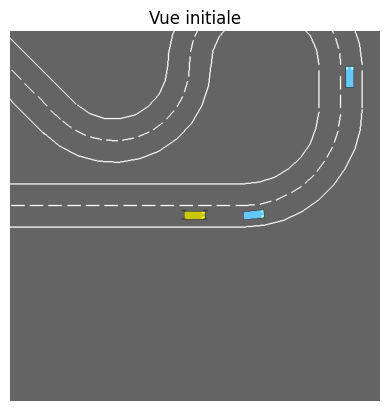

In [1]:

import os, time, pickle, psutil, gymnasium as gym, highway_env     # noqa: F401
import matplotlib.pyplot as plt

from stable_baselines3 import SAC
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import SubprocVecEnv
from stable_baselines3.common.callbacks import EvalCallback

ROOT       = os.path.abspath("..")                     # /project/task3
CONFIG_FN  = os.path.join(ROOT, "configs", "config3.pkl")
LOG_DIR    = os.path.join(ROOT, "logs", "sac_main")    # <- dossier spécifique
MODEL_DIR  = os.path.join(ROOT, "models")
os.makedirs(LOG_DIR,  exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

with open(CONFIG_FN, "rb") as f:
    cfg = pickle.load(f)

env_vis = gym.make("racetrack-v0", render_mode="rgb_array")
env_vis.unwrapped.configure(cfg)
obs, _ = env_vis.reset()
plt.imshow(env_vis.render()); plt.axis("off"); plt.title("Vue initiale"); plt.show()
env_vis.close()


In [2]:

CORES   = psutil.cpu_count(logical=False)
N_ENVS  = min(4, CORES // 2)        
print(f"{N_ENVS=} (CPU physiques : {CORES})")

vec_env = make_vec_env(
    "racetrack-v0",
    n_envs=N_ENVS,
    env_kwargs={"config": cfg},
    vec_env_cls=SubprocVecEnv if N_ENVS > 1 else None,
    vec_env_kwargs={"start_method": "fork"} if N_ENVS > 1 else None,
)

TOTAL_TS        = 60_000          # ≃ 3-4 mn CPU, 1-2 mn GPU
BUFFER_SIZE     = 60_000
LEARNING_STARTS = 500             # warm-up très court
BATCH_SIZE      = 128
TRAIN_FREQ      = 4               # collecte 4  → 1 update
GRADIENT_STEPS  = 1
LR              = 7e-4
GAMMA           = 0.99
TAU             = 0.02
policy_kwargs   = dict(net_arch=[128, 128])   # réseau plus petit & rapide

model = SAC(
    "MlpPolicy",
    vec_env,
    buffer_size=BUFFER_SIZE,
    learning_rate=LR,
    batch_size=BATCH_SIZE,
    train_freq=TRAIN_FREQ,
    gradient_steps=GRADIENT_STEPS,
    learning_starts=LEARNING_STARTS,
    gamma=GAMMA,
    tau=TAU,
    policy_kwargs=policy_kwargs,
    tensorboard_log=LOG_DIR,
    verbose=1,
)

eval_env = gym.make("racetrack-v0")
eval_env.unwrapped.configure(cfg)
eval_cb = EvalCallback(
    eval_env,
    eval_freq=15_000,      # 4 eval pour 60 k pas => suffisamment fin
    n_eval_episodes=3,
    log_path=LOG_DIR,
    deterministic=True,
)


N_ENVS=4 (CPU physiques : 24)
Using cpu device


In [3]:

start = time.time()
model.learn(
    total_timesteps=TOTAL_TS,
    tb_log_name="sac_fast",
    callback=eval_cb,
    progress_bar=True,
)
print(f"⏱  entraînement : {(time.time()-start)/60:.1f} min")


Logging to /usr/users/streamingjailbreakdetection/elbarichi_moh/Reinforcement-Learning-Project/task3/logs/sac_main/sac_fast_2


Output()

/usr/users/streamingjailbreakdetection/elbarichi_moh/miniconda3/lib/python3.12/site-packages/stable_baselines3/common/callbacks.py:418: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x7f9bf96d3d40> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7f9df4c2b4d0>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.5e+03  |
|    ep_rew_mean     | 17.7     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 104      |
|    time_elapsed    | 57       |
|    total_timesteps | 6004     |
| train/             |          |
|    actor_loss      | -4.22    |
|    critic_loss     | 0.017    |
|    ent_coef        | 0.786    |
|    ent_coef_loss   | -0.405   |
|    learning_rate   | 0.0007   |
|    n_updates       | 344      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.22e+03 |
|    ep_rew_mean     | 14.3     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 103      |
|    time_elapsed    | 116      |
|    total_timesteps | 12008    |
| train/             |          |
|    actor_loss      | -7.05    |
|    critic_loss     | 0.0111   |
|    ent_coef        | 0.605    |
|    ent_coef_loss   | -0.844   |
|    learning_rate   | 0.0007   |
|    n_updates       | 719      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.3e+03  |
|    ep_rew_mean     | 13.3     |
| time/              |          |
|    episodes        | 12       |
|    fps             | 102      |
|    time_elapsed    | 175      |
|    total_timesteps | 18012    |
| train/             |          |
|    actor_loss      | -8.98    |
|    critic_loss     | 0.0147   |
|    ent_coef        | 0.465    |
|    ent_coef_loss   | -1.29    |
|    learning_rate   | 0.0007   |
|    n_updates       | 1094     |
---------------------------------


: 

In [ ]:
model_path = os.path.join(MODEL_DIR, "sac_racetrack_fast.zip")
model.save(model_path)
with open(model_path.replace(".zip", "_info.txt"), "w") as f:
    f.write(
        f"algo=SAC fast\nn_envs={N_ENVS}\n"
        f"buffer={BUFFER_SIZE}\nbatch={BATCH_SIZE}\n"
        f"lr={LR}\ngamma={GAMMA}\n"
        f"total_ts/env={TOTAL_TS}\n"
    )
print("✓ modèle & méta sauvegardés →", model_path)


✓ modèle & méta sauvegardés → 
/usr/users/streamingjailbreakdetection/elbarichi_moh/Reinforcement-Learning-Project/task3/models/sac_racetrack.zip